BasicUNet features: (32, 32, 64, 128, 256, 32).


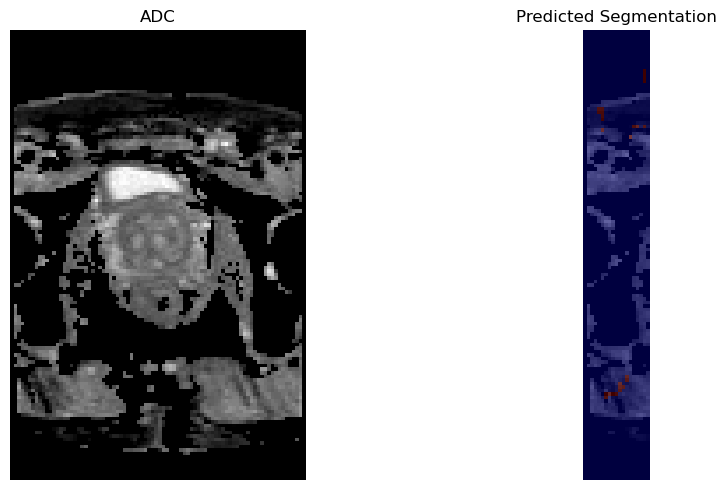

In [3]:
import torch
import SimpleITK as sitk
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord
from monai.networks.nets import BasicUNet
import matplotlib.pyplot as plt

# ==== Load model ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicUNet(spatial_dims=3, in_channels=2, out_channels=2).to(device)
model.load_state_dict(torch.load("prostate_seg_model.pth", map_location=device))
model.eval()

# ==== Select a patient ====
proxid = "ProstateX-0100"  # Change this to test other patients
adc_path = f"images/{proxid}_adc.nii.gz"
ktrans_path = f"images/{proxid}_ktrans.nii.gz"

# ==== Preprocessing ====
inference_transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityd(keys="image"),
    ToTensord(keys="image")
])

# Your image is already multi-modal
sample = {"image": [adc_path, ktrans_path]}
sample = inference_transforms(sample)

input_tensor = sample["image"].unsqueeze(0).to(device)  # Add batch dim

# ==== Predict ====
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()  # shape: (D, H, W)

# ==== Load original ADC for visual reference ====
adc_img = sitk.ReadImage(adc_path)
adc_np = sitk.GetArrayFromImage(adc_img)  # shape: (D, H, W)

# ==== Visualize a slice ====

depth = min(adc_np.shape[0], pred.shape[0])  # Use the smallest available depth
slice_idx = depth // 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("ADC")
plt.imshow(adc_np[slice_idx], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation")
plt.imshow(adc_np[slice_idx], cmap='gray')
plt.imshow(pred[slice_idx], alpha=0.5, cmap='jet')
plt.axis('off')

plt.tight_layout()
plt.show()
